In [10]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy

%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

import gfb_utils as g
import nsd_utils as n


In [3]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [4]:
# Loading a set of actual images

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn

n_samples = 5000
trn_stim_data = image_uncolorize_fn(image_data)
trn_stim_data = trn_stim_data[ordering[0:n_samples]]

images = trn_stim_data


block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [5]:
# Parameters

n_ori = 8
n_sf = 3

# n_ori = 36
# n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 1
n_sd_out = 4

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [6]:
# This is the version of the filtering code that came from NSD OSF repository

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import logspace

pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
# pix_per_cycle = 6

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    



In [7]:
# Get features using this method

n_images = 5000
sample_batch_size=2
n_batches = int(np.ceil(n_images/sample_batch_size))
n_pixels = process_at_size[0]
n_features = len(_gaborizer.orients_deg)*len(_gaborizer.cyc_per_stim)

t_start = time.time()

for bb in range(n_batches):
    
    image_range = np.arange(bb*sample_batch_size, min((bb+1)*sample_batch_size, n_images),1)

    t = time.time()
    
    fmaps = _fmaps_fn(_to_torch(images[image_range],device=device))

    elapsed = time.time() - t
    
    if bb==0:
        maps_gab = [np.zeros(shape=(n_images, fm.shape[1], fm.shape[2], fm.shape[2])) for fm in fmaps]

    for sf in range(len(fmaps)):        
        maps_gab[sf][image_range,:,:,:] = fmaps[sf].cpu().detach().numpy()
    
print(np.shape(maps_gab[1]))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)


/home/mmhender/myenv/lib/python3.7/site-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(5000, 8, 62, 62)
total time is 24.60 s


In [8]:
# Get features for a single RF location

x,y,sigma = [0,0,0.05]

features_first_order = get_features_in_prf([x,y,sigma], _fmaps_fn, images[0:n_images], 
                                   sample_batch_size, aperture=1.0, device=device)

In [11]:
# Create all second-order combinations of first order features, multiplication.
features_second_order = np.tile(features_first_order, [1,n_features]) * np.repeat(features_first_order, n_features, axis=1)

# a list to remember which order the feats go in
feature_combs = np.concatenate((np.expand_dims(np.tile(np.arange(0,n_features), [n_features]),1),
                                np.expand_dims(np.repeat(np.arange(0,n_features), n_features),1)), axis=1)

# to check and make sure ordering of combinations makes sense
ind = 343
print(features_second_order[0,ind])
print(features_first_order[0,np.mod(ind, n_features)] * features_first_order[0,int(np.ceil(ind/n_features))-1])
print(features_first_order[0,feature_combs[ind,0]] * features_first_order[0,feature_combs[ind,1]])

# create full feature space that includes first and second order features.

features_full = np.concatenate((scipy.stats.zscore(features_first_order, axis=None),
                                scipy.stats.zscore(features_second_order, axis=None)), axis=1)

0.00011919389
0.00011919389
0.00011919389


In [12]:
from src.torch_fwrf import get_features_in_prf_second_order

features_full_new, zstats  = get_features_in_prf_second_order([x,y,sigma], _fmaps_fn, images[0:n_images], 
                                   sample_batch_size, aperture=1.0, device=device)

In [13]:
print(features_full[0:10,200:210])
print(features_full_new[0:10,200:210])

[[-0.26545346 -0.2624418  -0.1704683   0.09168033  1.0559762   1.1346699
   0.02275659 -0.13201164 -0.34397832 -0.3805921 ]
 [ 0.77565944  1.0176067   0.26123446 -0.06429168 -0.12220524 -0.17118828
  -0.22253996  0.36109906 -0.26625112 -0.2778299 ]
 [ 0.36308622  0.00801594 -0.11790322 -0.0078314   0.20897424 -0.04905101
   0.01413256  0.21611352 -0.45867497 -0.43265623]
 [ 0.33107826  0.27714035  0.3773391   0.5616439   0.41434762  0.8896085
   1.1805153   0.7216086  -0.24944338 -0.16625394]
 [ 0.4078639  -0.19675973 -0.49673855 -0.42889786 -0.29274622 -0.34243274
  -0.49782947 -0.27515805 -0.36745408 -0.44330865]
 [ 0.14845169  0.24295586  0.6432328   0.92636204  0.8722704   0.3263406
  -0.01936639  0.21030107  0.5209093   0.19007933]
 [-0.13878249  0.0706194   1.0249747   0.32728514 -0.06344533  0.05203586
  -0.09276959 -0.07182445 -0.30383205 -0.24840087]
 [ 1.4522055   1.3361658   0.36495695  0.24160635  0.25338092  0.15377443
   0.16410513  0.19155078  0.09548855 -0.08210795]
 [ 

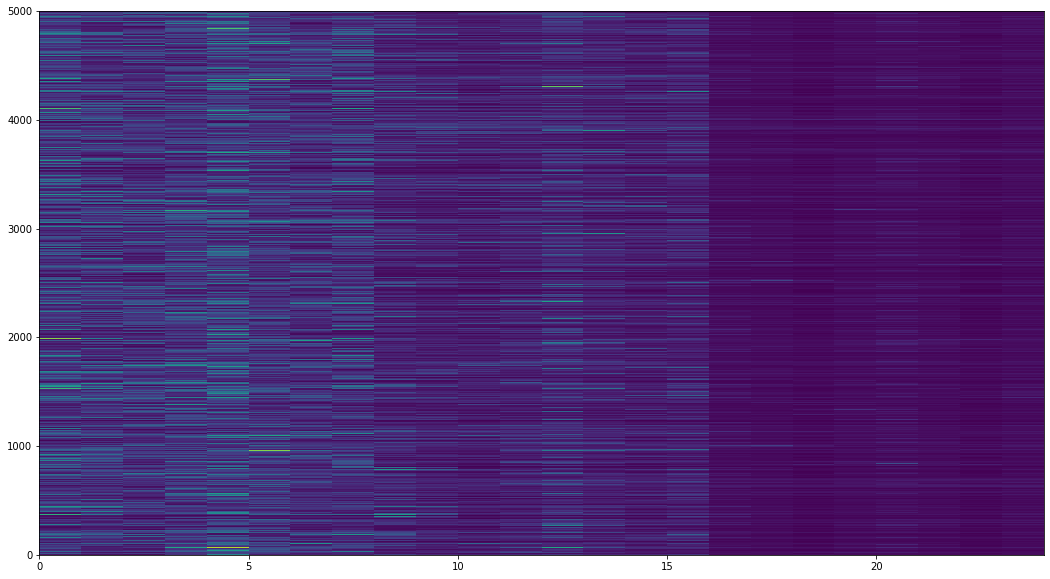

In [14]:
# Visualize the design matrix from these first order features

plt.figure(figsize=(18,10));
plt.pcolormesh(scipy.stats.zscore(features_first_order, axis=None))
# plt.pcolormesh(features_first_order)

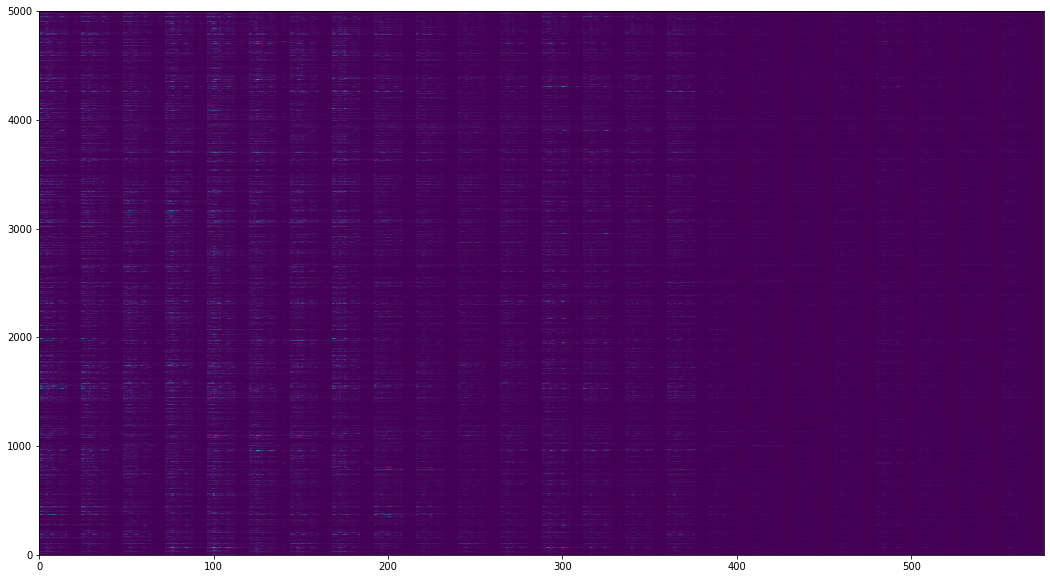

In [15]:

plt.figure(figsize=(18,10));
plt.pcolormesh(features_second_order)

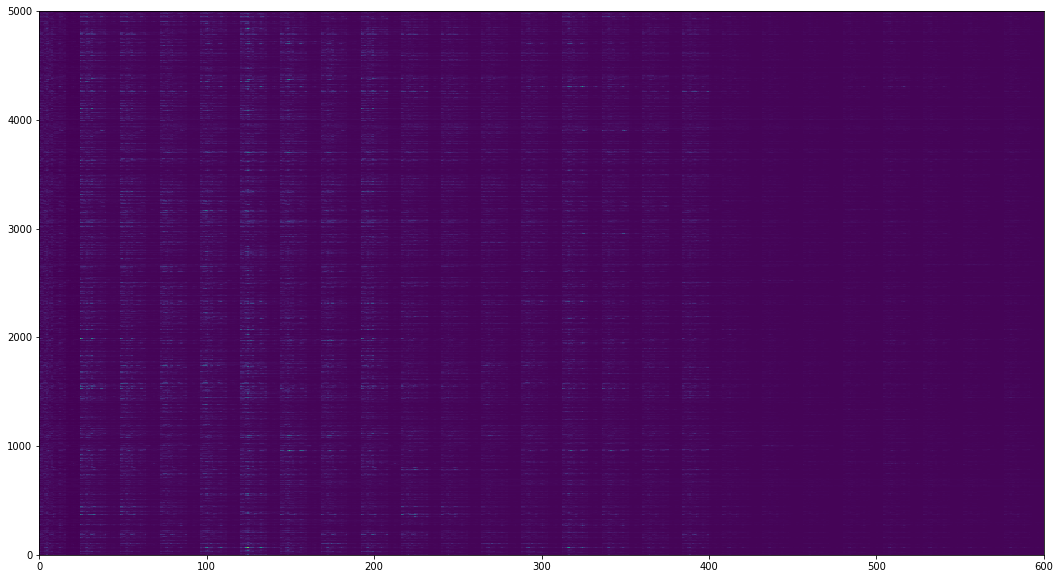

In [16]:

plt.figure(figsize=(18,10));
plt.pcolormesh(features_full)

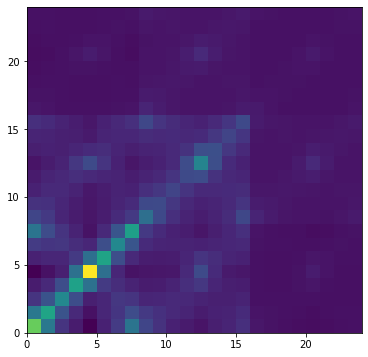

In [18]:
# covariance of first order features
cov_first_order = np.cov(np.transpose(features_first_order))
plt.figure(figsize=(6,6));
plt.pcolormesh(cov_first_order)

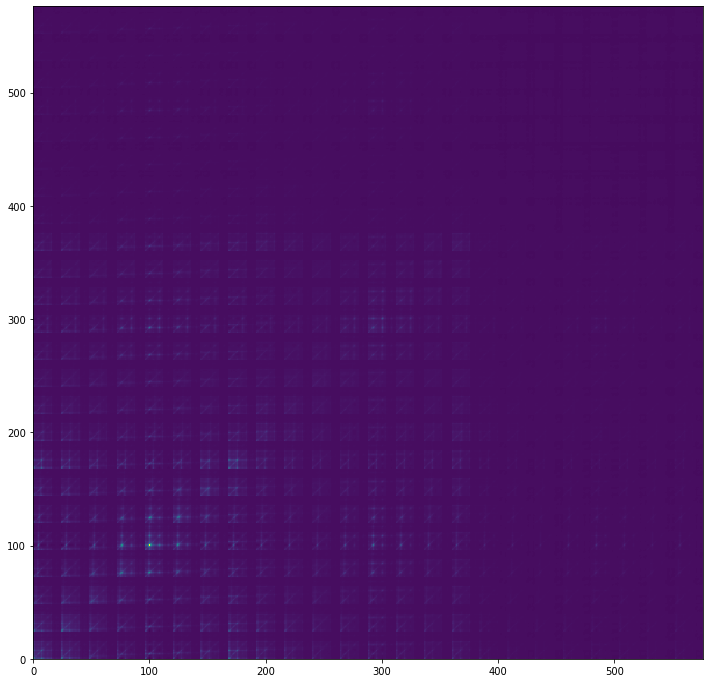

In [19]:
# covar of second-order
cov_second_order = np.cov(np.transpose(features_second_order))
plt.figure(figsize=(12,12));
plt.pcolormesh(cov_second_order)

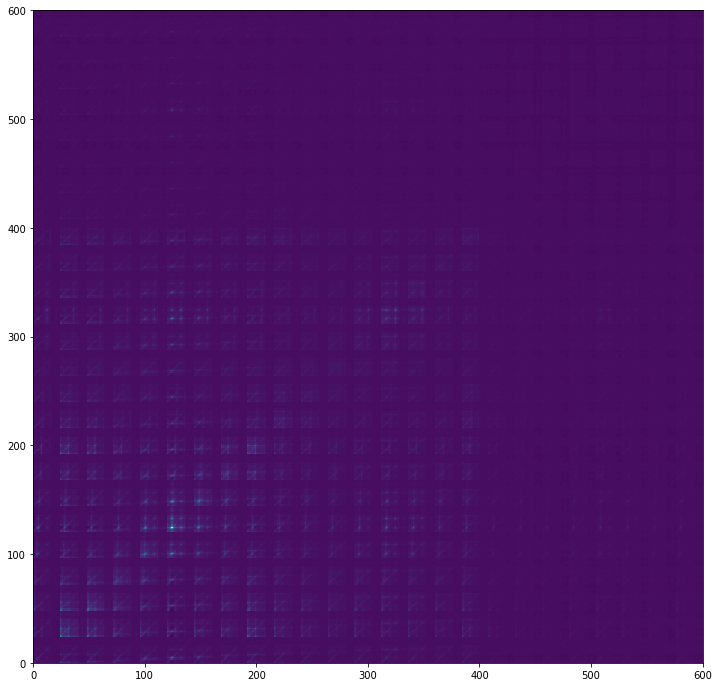

In [20]:
# covar of full set
cov_full = np.cov(np.transpose(features_full))
plt.figure(figsize=(12,12));
plt.pcolormesh(cov_full)

In [21]:
# PCA on each set of features

from sklearn import decomposition
import scipy

pca = decomposition.PCA()

print('running pca (original size %d by %d)'%(np.shape(features_first_order)[0],
                                              np.shape(features_first_order)[1]))
# pca.fit(scipy.stats.zscore(features_first_order, axis=0))
pca.fit(features_first_order)
scores_first = pca.transform(features_first_order)
pca_wts_first = pca.components_
pct_expl_var_first = pca.explained_variance_
pct_expl_var_first = pct_expl_var_first/sum(pct_expl_var_first)*100


print('running pca (original size %d by %d)'%(np.shape(features_second_order)[0],
                                              np.shape(features_second_order)[1]))
# pca.fit(scipy.stats.zscore(features_second_order, axis=0))
pca.fit(features_second_order)
scores_second = pca.transform(features_second_order)
pca_wts_second = pca.components_
pct_expl_var_second = pca.explained_variance_
pct_expl_var_second = pct_expl_var_second/sum(pct_expl_var_second)*100


print('running pca (original size %d by %d)'%(np.shape(features_full)[0],
                                              np.shape(features_full))[1])
# pca.fit(scipy.stats.zscore(features_full, axis=0))
pca.fit(features_full)
scores_full = pca.transform(features_full)
pca_wts_full = pca.components_
pct_expl_var_full = pca.explained_variance_
pct_expl_var_full = pct_expl_var_full/sum(pct_expl_var_full)*100

running pca (original size 5000 by 24)
running pca (original size 5000 by 576)
running pca (original size 5000 by 600)


15
66
70


Text(0.5, 1.0, 'concatenated')

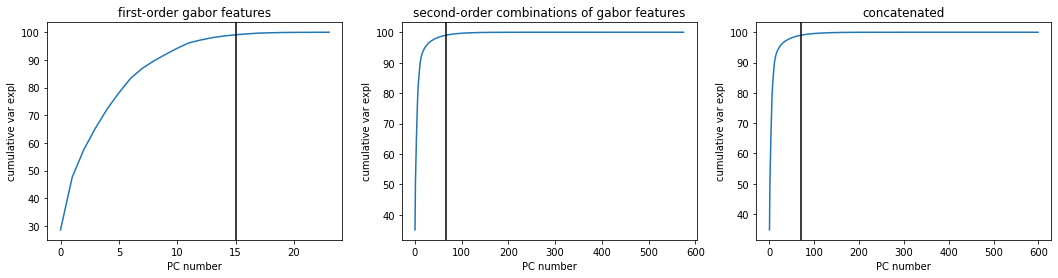

In [22]:
# Plot pct var for each set of features

plt.figure(figsize=(18,4));
plt.subplot(1,3,1)

plt.plot(np.cumsum(pct_expl_var_first))
ncompneeded_first = np.where(np.cumsum(pct_expl_var_first)>99)[0][0]
feat_reduced_first = scores_first[:,0:ncompneeded_first]
plt.axvline(ncompneeded_first,color='k')
print(ncompneeded_first)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')
plt.title('first-order gabor features')

plt.subplot(1,3,2)
plt.plot(np.cumsum(pct_expl_var_second))
ncompneeded_second = np.where(np.cumsum(pct_expl_var_second)>99)[0][0]
feat_reduced_second = scores_second[:,0:ncompneeded_second]
plt.axvline(ncompneeded_second,color='k')
print(ncompneeded_second)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')
plt.title('second-order combinations of gabor features')

plt.subplot(1,3,3)
plt.plot(np.cumsum(pct_expl_var_full))
ncompneeded_full = np.where(np.cumsum(pct_expl_var_full)>99)[0][0]
feat_reduced_full = scores_full[:,0:ncompneeded_full]
plt.axvline(ncompneeded_full,color='k')
print(ncompneeded_full)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')
plt.title('concatenated')


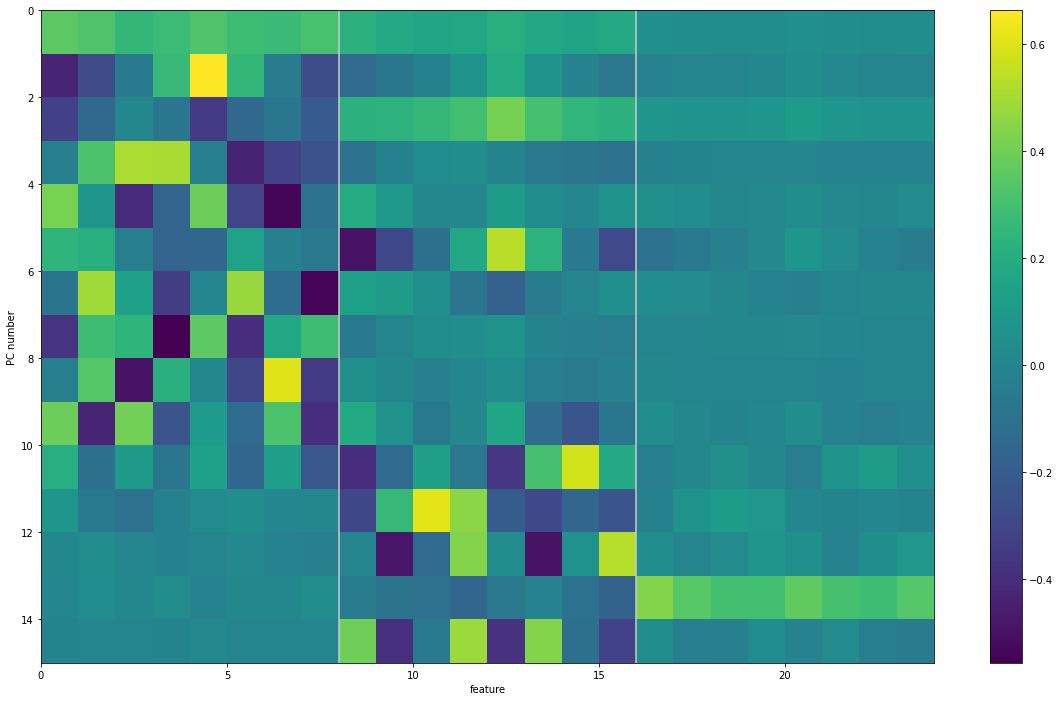

In [23]:
# visualize the PCs (feature space wts)

plt.figure(figsize=(20,12));
plt.pcolormesh(pca_wts_first[0:ncompneeded_first,:])
for ii in np.arange(0,n_features, n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0, 0.5, 'PC weight')

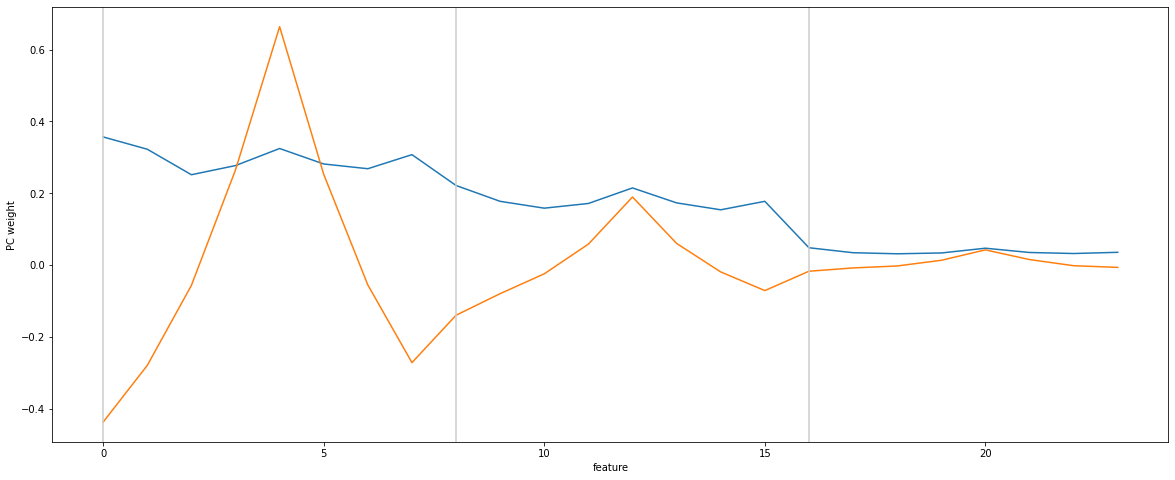

In [24]:
plt.figure(figsize=(20,8));
plt.plot(np.transpose(pca_wts_first[0:2,:]))
for ii in np.arange(0,n_features,n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC weight')

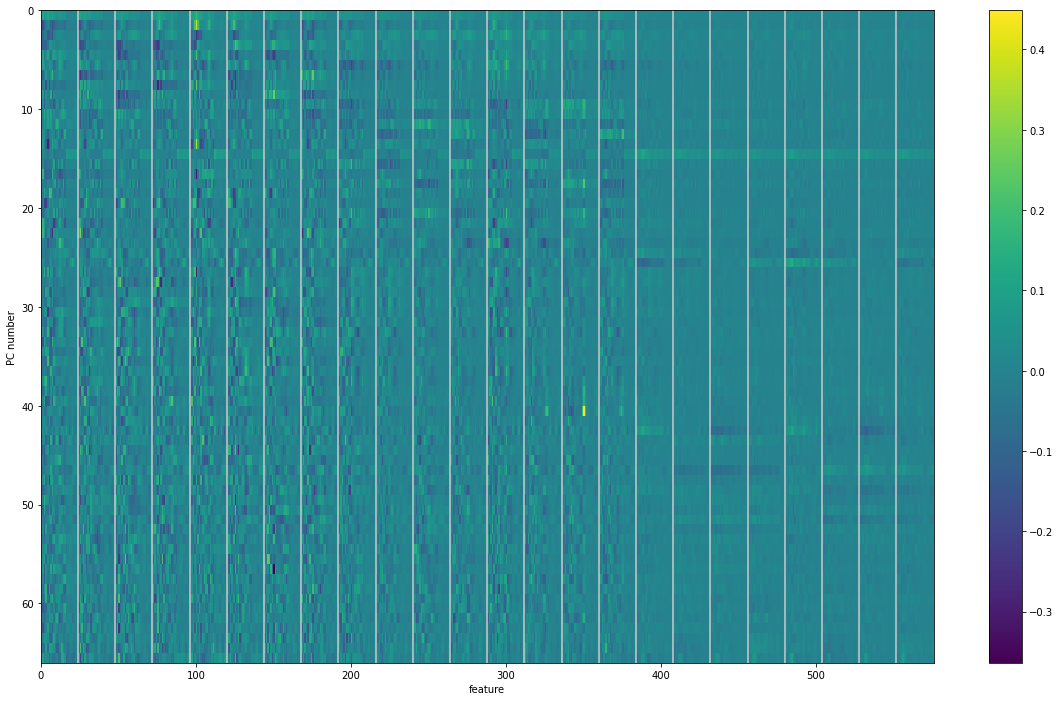

In [25]:
# visualize the PCs (feature space wts)

plt.figure(figsize=(20,12));
plt.pcolormesh(pca_wts_second[0:ncompneeded_second,:])
for ii in np.arange(0,n_features*n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0, 0.5, 'PC weight')

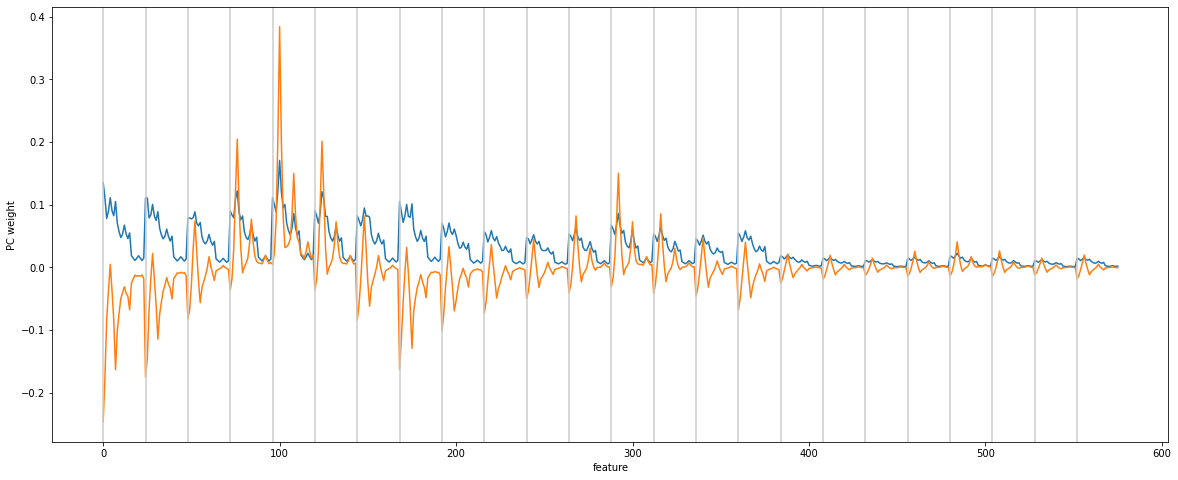

In [26]:
plt.figure(figsize=(20,8));
plt.plot(np.transpose(pca_wts_second[0:2,:]))
for ii in np.arange(0,n_features*n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC weight')

Text(0, 0.5, 'PC weight')

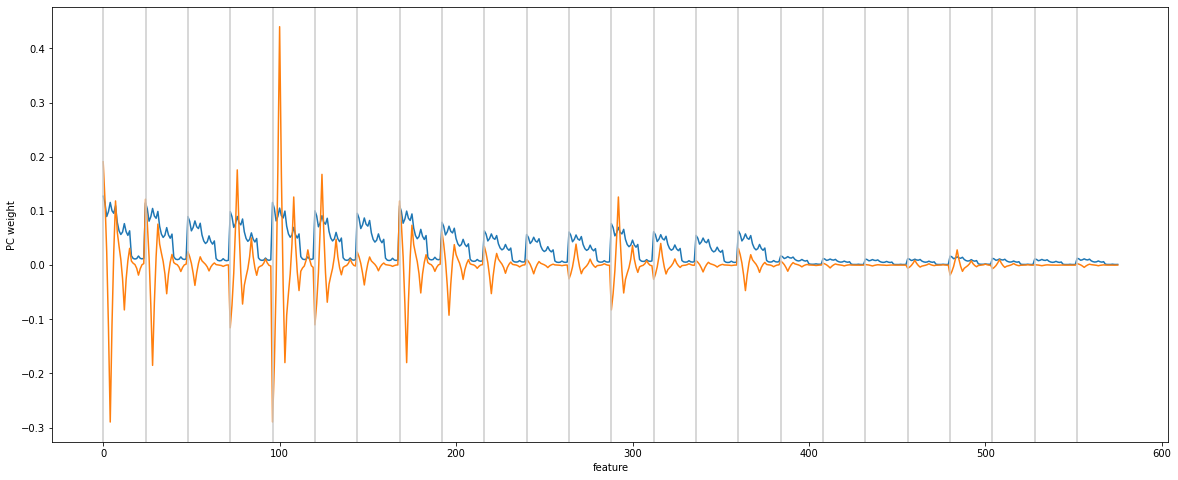

In [27]:
# want to see how the full-space pc weights compare to combinations of first-order pc weights.
pca_wts_combined = np.tile(pca_wts_first, [1,n_features]) * np.repeat(pca_wts_first, n_features, axis=1)

plt.figure(figsize=(20,8));
plt.plot(np.transpose(pca_wts_combined[0:2,:]))
for ii in np.arange(0,n_features*n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC weight')

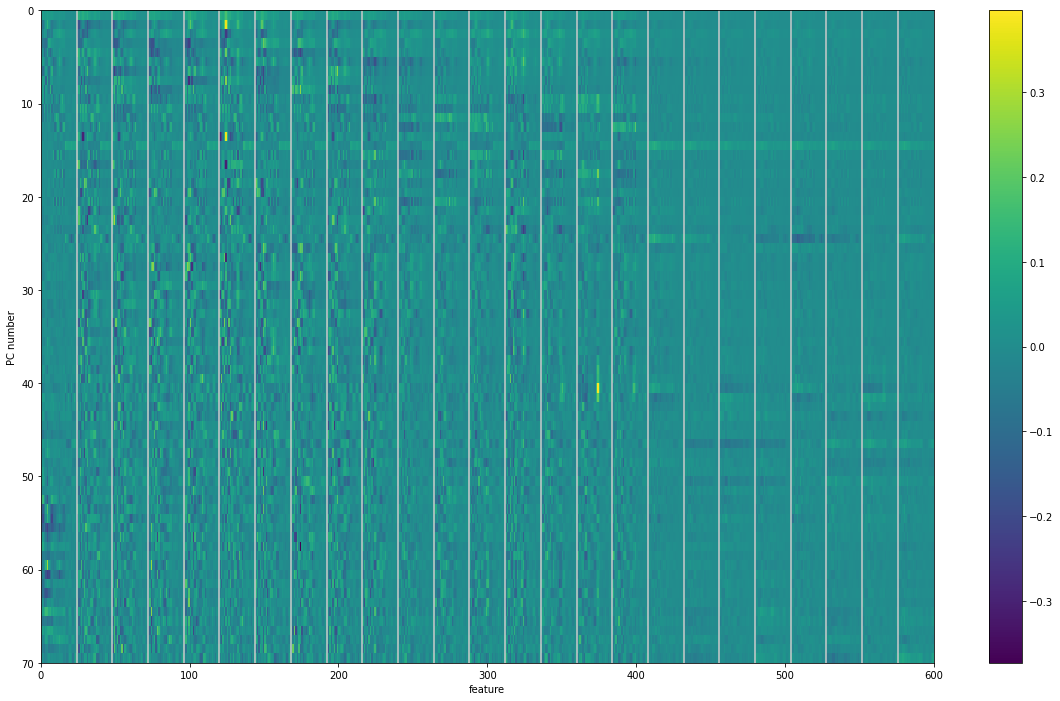

In [28]:
# visualize the PCs (feature space wts)

plt.figure(figsize=(20,12));
plt.pcolormesh(pca_wts_full[0:ncompneeded_full,:])
for ii in np.arange(0,n_features*n_features+n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.gca().invert_yaxis()
plt.colorbar()

Text(0, 0.5, 'PC weight')

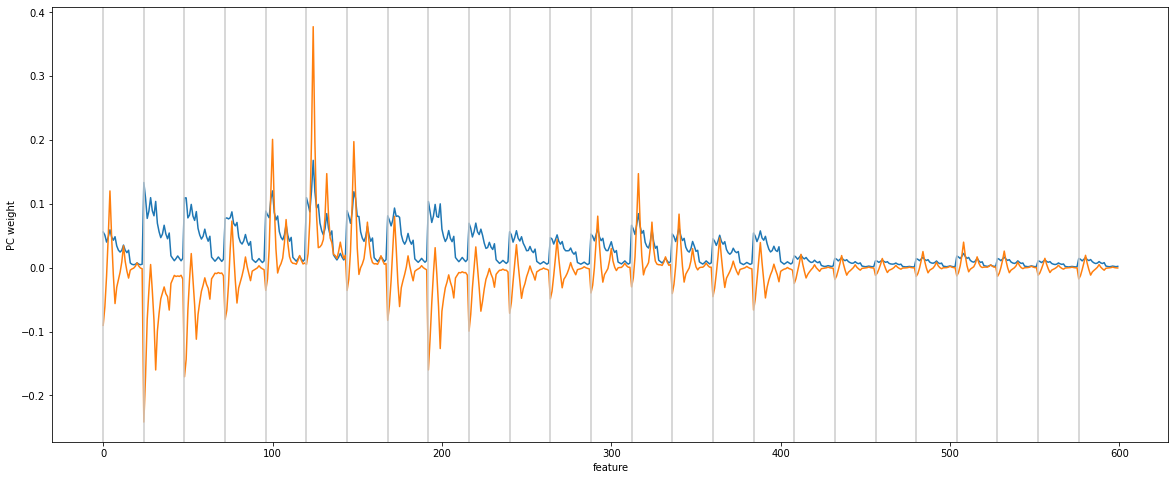

In [29]:
plt.figure(figsize=(20,8));
plt.plot(np.transpose(pca_wts_full[0:2,:]))
for ii in np.arange(0,n_features*n_features+n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC weight')